In [94]:
!pip install scanpy
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00:00:01


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

To do:
- import data
- subset features
- calculate neighbors
- UMAP
- pseudotime

In [3]:
# Load data
data = pd.read_csv('../data/mitocells.csv', index_col=0)

print('Data loaded.')

Data loaded.


In [11]:
data

,3d_image,angle,bbox_max_x,bbox_max_y,bbox_max_z,bbox_min_x,bbox_min_y,bbox_min_z,bf_clip_hi,bf_clip_lo,...,structure_clip_hi,structure_clip_lo,structure_connected_components,structure_volume,this_cell_index,this_cell_nbr_complete,this_cell_nbr_dist_2d,WellId,WorkflowId,split
0,s3://allencell-hipsc-cytodata/register/916216....,-31.077479,279,248,76,76,108,10,40668.0,30404.0,...,670,430,79.0,0.194214,19,1,"[(916202, 191.90299137469285), (916203, 140.56...",209390,['Pipeline 4.4'],train
1,s3://allencell-hipsc-cytodata/register/459620....,-0.707439,278,243,105,42,53,17,27645.0,21314.0,...,490,400,4.0,0.032098,6,1,"[(459624, 204.5972913202186), (459626, 118.164...",50264,['Pipeline 4.1'],valid
2,s3://allencell-hipsc-cytodata/register/971144....,-50.739680,426,399,67,63,157,14,22597.0,18347.0,...,490,410,NaN,NaN,7,0,[],123327,['Pipeline 4.2'],test
3,s3://allencell-hipsc-cytodata/register/296702....,50.555150,355,319,75,88,161,13,43559.0,35584.0,...,1700,475,1.0,0.232458,19,0,"[(296697, 156.4981600836318), (296700, 151.781...",20408,['Pipeline 4'],train
4,s3://allencell-hipsc-cytodata/register/828656....,69.517438,393,335,87,102,116,18,31590.0,24323.0,...,800,440,164.0,0.161728,15,0,"[(828642, 198.73757282374692), (828643, 229.16...",165425,['Pipeline 4.4'],train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8174,s3://allencell-hipsc-cytodata/register/313435....,-73.435434,325,278,118,65,96,14,24649.0,17452.0,...,1700,475,432.0,0.274022,4,0,"[(313434, 133.57224274297576), (313441, 136.38...",17525,['Pipeline 4'],test
8175,s3://allencell-hipsc-cytodata/register/271165....,-71.751304,402,306,102,114,132,10,46401.0,34388.0,...,815,410,56.0,0.355464,30,0,"[(271144, 150.61272160548725), (271146, 188.76...",7348,['Pipeline 4'],train
8176,s3://allencell-hipsc-cytodata/register/773111....,51.938606,410,365,104,106,158,10,22976.0,17334.0,...,800,440,354.0,0.202355,28,0,"[(773084, 74.06491566790208), (773085, 226.553...",73975,['Pipeline 4.1'],train
8177,s3://allencell-hipsc-cytodata/register/611603....,-80.447116,485,300,108,61,105,14,22396.0,17548.0,...,800,440,286.0,0.276720,9,0,"[(611598, 109.87087394056745), (611599, 243.48...",72631,['Pipeline 4.1'],train


In [4]:
data.columns

Index(['3d_image', 'angle', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z',
       'bbox_min_x', 'bbox_min_y', 'bbox_min_z', 'bf_clip_hi', 'bf_clip_lo',
       'cell_height', 'cell_stage', 'cell_surface_area', 'cell_volume',
       'CellId', 'Cellular Component', 'center_slice',
       'Description (from Uniprot)', 'dna_clip_hi', 'dna_clip_lo', 'edge_flag',
       'fits_x', 'fits_y', 'fits_z', 'FOVId', 'gene', 'InstrumentId',
       'max_projection_x', 'max_projection_y', 'max_projection_z',
       'mean_projection_x', 'mean_projection_y', 'mean_projection_z',
       'median_projection_x', 'median_projection_y', 'median_projection_z',
       'membrane_clip_hi', 'membrane_clip_lo', 'meta_colony_area',
       'meta_colony_centroid', 'meta_colony_label', 'meta_fov_edgedist',
       'meta_fov_outside_overview', 'meta_fov_position', 'meta_fov_xcoord',
       'meta_fov_ycoord', 'meta_imaging_mode', 'meta_plate_bad_segmentation',
       'meta_plate_confluency', 'meta_well_passage_at_imaging',
     

In [16]:
# Load autoencoder embeddings
import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")

with download_artifact("dataframes/embeddings.csv", experiment_name="vae_3ch", run_name="teamx_bfdnamembrane_zproj_20221019_212844") as path:
    embeddings = pd.read_csv(path)

with download_artifact("dataframes/stats_per_dim_test.csv", experiment_name="vae_3ch", run_name="teamx_bfdnamembrane_zproj_20221019_212844") as path:
    kl_per_dimension = pd.read_csv(path)
    
# Get dimension ranks based on KLD values
from cytodata_aics.vae_utils import get_ranked_dims
ranked_z_dim_list, mu_std_list, mu_mean_list = get_ranked_dims(kl_per_dimension, 0, 8)
ranked_z_dim_list = [f"mu_{i}" for i in ranked_z_dim_list]
updated_ranks = [f"mu_{i+1}" for i in range(8)]
embeddings = embeddings[[i for i in embeddings.columns if i in ranked_z_dim_list] + ['CellId']]
# Rank embeddings from 1 to 8
rename_cols = {}
for i, j in zip(ranked_z_dim_list, updated_ranks):
    rename_cols[i] = j
embeddings.rename(columns = rename_cols, inplace=True)
embeddings = embeddings.reindex(sorted(embeddings.columns), axis=1)
embeddings = embeddings.merge(data[['CellId'] + [i for i in data.columns if "shape_mode" in i] + ['nuclear_volume', 'nuclear_height', 'nuclear_surface_area']], on = 'CellId')

/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:144: FutureWarning: ``mlflow.tracking.fluent.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  for _experiment in mlflow.list_experiments():
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1066: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  return MlflowClient().list_experiments(
/opt/conda/lib/python3.10/site-packages/serotiny/ml_ops/mlflow_utils.py:156: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  for run_info in mlflow.list_run_infos(experiment_id=experiment_id):
/opt/conda/lib/python3.10/site-packages/mlflow/tracking/fluent.py:1599: FutureWarning: ``mlflow.tracking.client.MlflowClient.li

In [20]:
# Subset to relevant features
data_sub = embeddings.filter(like='mu', axis=1)

In [22]:
# Convert data to AnnData
obj = sc.AnnData(data_sub)

obj.obs['cell_stage'] = data['cell_stage'].values
obj.obs['CellId'] = data['CellId'].values

# Scale
sc.pp.scale(obj)

/tmp/ipykernel_20814/1985355170.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  obj = sc.AnnData(data_sub)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
# Calculate neighborhood graph
sc.pp.neighbors(obj, n_pcs=0)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


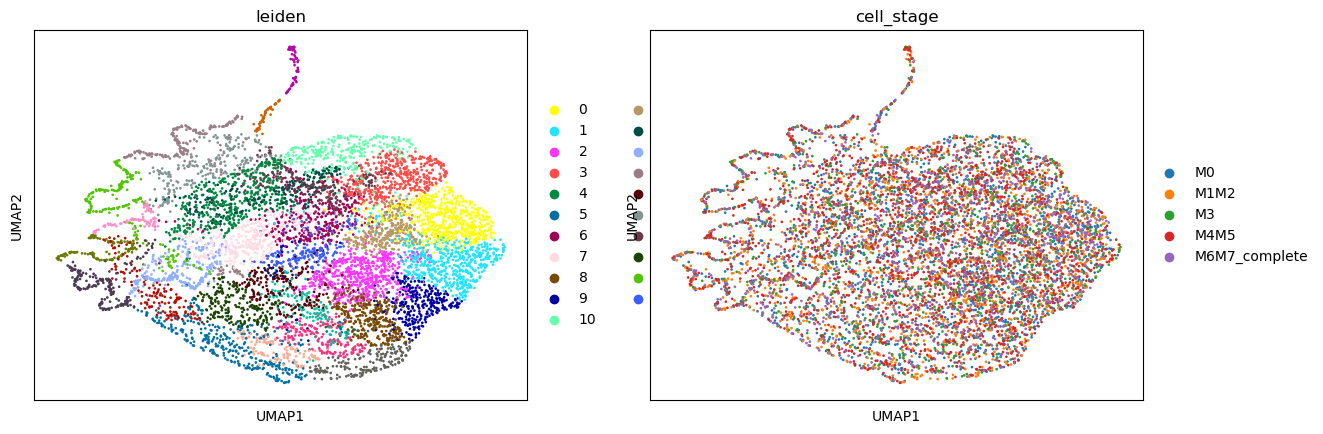

In [26]:
# Plot UMAP
sc.tl.leiden(obj)
sc.tl.umap(obj)
sc.pl.umap(obj, color=['leiden','cell_stage'])

In [150]:
obj.obs['nc_ratio'] = data['nuclear_volume'].values / data['cell_volume'].values

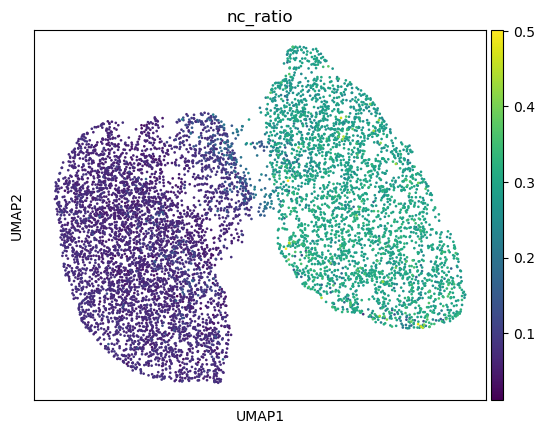

In [151]:
sc.pl.umap(obj, color='nc_ratio')

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='nc_ratio', ylabel='Count'>

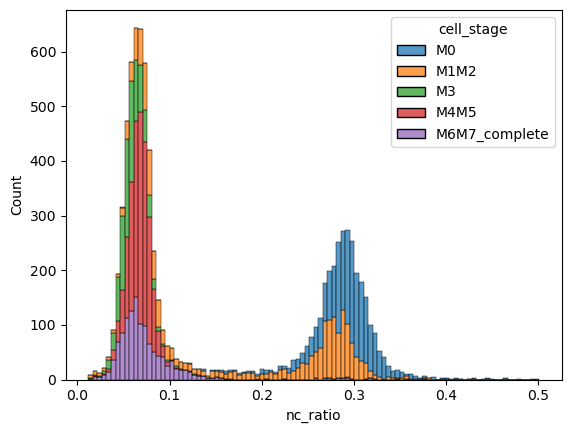

In [161]:
data['nc_ratio'] = data['nuclear_volume'] / data['cell_volume']
sns.histplot(data=data,x='nc_ratio',hue='cell_stage',bins=100,multiple='stack')

In [148]:
obj[(obj.obs['leiden'] == '4') &
   (obj.obs['cell_stage'] == 'M1M2')].obs

,cell_stage,CellId,leiden,dpt_pseudotime
2003,M1M2,903040,4,0.701334
2010,M1M2,380635,4,0.787350
2024,M1M2,321391,4,0.765389
2027,M1M2,988762,4,0.728207
2051,M1M2,521897,4,0.747110
...,...,...,...,...
3957,M1M2,502113,4,0.768756
3974,M1M2,888439,4,0.813994
3978,M1M2,971061,4,0.796143
3980,M1M2,633850,4,0.757694


In [142]:
obj[obj.obs['leiden'] == '18'].obs

,cell_stage,CellId,leiden
2018,M1M2,810430,18
2023,M1M2,303432,18
2035,M1M2,932551,18
2042,M1M2,995983,18
2056,M1M2,867300,18
...,...,...,...
7365,M6M7_complete,531129,18
7521,M6M7_complete,883365,18
7657,M6M7_complete,809672,18
7668,M6M7_complete,839687,18


In [155]:
# Compute diffusion map
sc.tl.diffmap(obj)

# Define root cell
obj.uns['iroot'] = np.flatnonzero(obj.obs['leiden'] == '8')[0]

In [156]:
# Calculate diffusion pseudotime

sc.tl.dpt(obj, n_branchings=0, n_dcs=10)

In [157]:
obj

AnnData object with n_obs × n_vars = 8179 × 6
    obs: 'cell_stage', 'CellId', 'leiden', 'dpt_pseudotime', 'nc_ratio'
    var: 'mean', 'std'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cell_stage_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


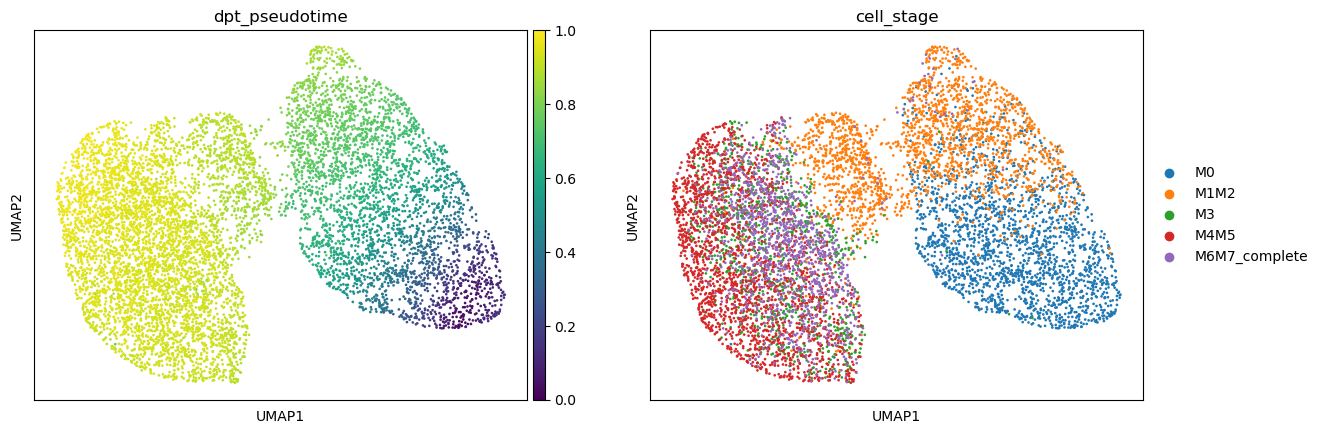

In [158]:
sc.pl.umap(obj, color=['dpt_pseudotime', 'cell_stage'])

In [193]:
obj.obs['log_dpt_pseudotime'] = np.log(1 - obj.obs['dpt_pseudotime'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


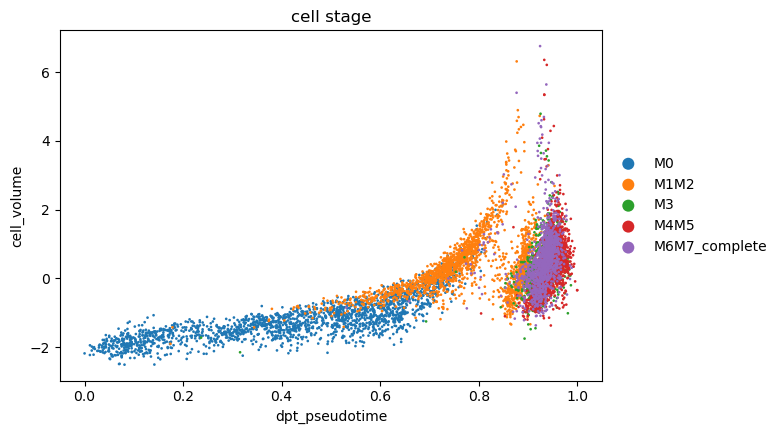

In [202]:
sc.pl.scatter(obj, x='dpt_pseudotime', y='cell_volume', color='cell_stage')

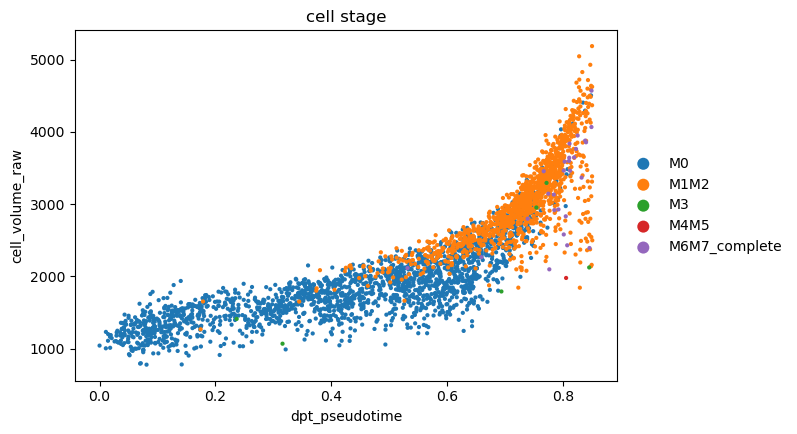

In [248]:
# Add volumes
obj.obs['cell_volume_raw'] = data_sub['cell_volume'].values

# Examine only dpt from 0 to 0.85
obj_early = obj[obj.obs['dpt_pseudotime'] < 0.85]

sc.pl.scatter(obj_early, x='dpt_pseudotime', y='cell_volume_raw', color='cell_stage')

In [250]:
# Fit exponential
def func(x, a, k, b):
    return a * np.exp(k * x) + b


xdata = obj_early.obs['dpt_pseudotime'].values
ydata = obj_early.obs['cell_volume_raw'].values
a0 = 1000
k0 = 1
b0 = 1000

popt, pcov = curve_fit(func, xdata, ydata, p0=[a0, k0, b0], bounds=(0, np.inf))

Text(0, 0.5, 'cell volume (raw)')

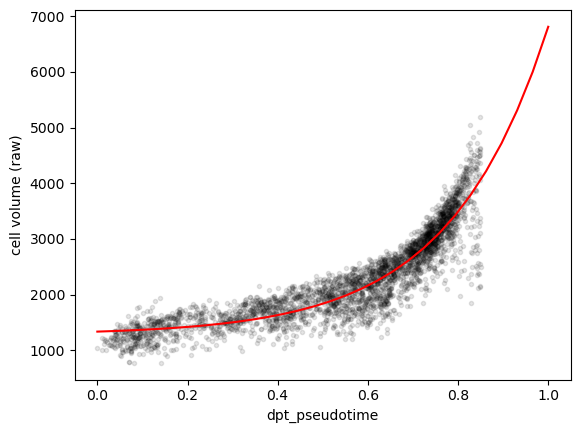

In [260]:
# Plot
a_fit = popt[0]
k_fit = popt[1]
b_fit = popt[2]

x_fit = np.linspace(0, 1, 30)

plt.plot(obj_early.obs['dpt_pseudotime'],
         obj_early.obs['cell_volume_raw'],
         'k.',
        alpha=0.1)
plt.plot(x_fit,
         func(x_fit, a_fit, k_fit, b_fit),
         'r-')
plt.xlabel('dpt_pseudotime')
plt.ylabel('cell volume (raw)')

In [263]:
1 / k_fit

0.2178369589722949

In [215]:
obj_early[:,'cell_volume'].X.squeeze().shape

(3258,)

In [182]:
# Bin in pseudotime
bin_id, bins = pd.cut(obj.obs['dpt_pseudotime'], bins=10, retbins=True, labels=False)
obj.obs['dpt_pseudotime_bin'] = bin_id

In [191]:
dpt_bins = pd.DataFrame()
dpt_bins['bin_freq'] = obj.obs['dpt_pseudotime_bin'].value_counts(normalize=True)
dpt_bins['bin_val'] = bins[1:]
dpt_bins['cumsum'] = 1 - dpt_bins.cumsum()['bin_freq']

In [192]:
dpt_bins

,bin_freq,bin_val,cumsum
9,0.515344,0.1,0.484656
7,0.111016,0.2,0.373640
8,0.110527,0.3,0.263113
6,0.076293,0.4,0.186820
5,0.056364,0.5,0.130456
4,0.033378,0.6,0.097078
3,0.031544,0.7,0.065534
1,0.025676,0.8,0.039858
0,0.020907,0.9,0.018951
2,0.018951,1.0,0.000000
